In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce
from sympy import Symbol, diff, lambdify

%matplotlib notebook

# Item 4.2
Cost function: 
$f(x)= -5x^5 + 4x^4 - 12x^3 + 11x^2 - 2x + 1 $

Interval: 
$[-0.5,0.5]$

Uncertanty range:
$10^{-5}$

### A. Dichotomous search

In [67]:
def dichoSearch(lower,upper,cost,step=3e-6,delta=1e-5,eps=1e-15,verbose=False):

    while abs(upper - lower) > delta:
        if verbose:
            print('Range: ',abs(lower - upper))
        
        x = (lower + upper)/2
        costLow = cost(x - step/2)
        costUp = cost(x + step/2)

        if np.abs(costLow - costUp) < eps:
            upper = x + step/2
            lower = x - step/2
        elif costLow < costUp:
            upper = x + step/2
        else:
            # costLow > costUp:
            lower = x - step/2
            
    return x, costLow

### B. Fibonacci search

In [74]:
def fiboSearch(lower,upper,cost,n,verbose=False):
    
    fib = lambda n:reduce(lambda x,n:[x[1],x[0]+x[1]], range(n),[0,1])
    
    interval = upper - lower
    
    fibVals = fib(n)
    interval = (fibVals[0]/fibVals[1])*interval
    x_a = upper - interval
    x_b = lower + interval
    fx_a = cost(x_a)
    fx_b = cost(x_b)
    if verbose:
            print('Range: ',abs(lower - upper))
    
    for k in range(1,n-2):
        fibVals = fib(n-k)
        interval = (fibVals[0]/fibVals[1])*interval
        
        if x_a > x_b:
            return x_a, fx_a
        
        if verbose:
            print('Range: ',interval)
        
        if fx_a > fx_b:
            lower = x_a
            x_a = x_b
            x_b = lower + interval
            fx_a = fx_b
            fx_b = cost(x_b)
            
        else:
            upper = x_b
            x_b = x_a
            x_a = upper - interval
            fx_b = fx_a
            fx_a = cost(x_a)

    return x_a, fx_a

### C. Golden-section search

In [1]:
def goldenSearch(lower,upper,cost,delta=1e-5,eps=1e-15,verbose=False):
    
    K = (1 + np.sqrt(5))/2
    
    interval = upper - lower
    interval /= K
    x_a = upper - interval
    x_b = lower + interval
    fx_a = cost(x_a)
    fx_b = cost(x_b)
    if verbose:
            print('Range: ',abs(lower - upper))
    
    while x_a < x_b and interval > delta:
        
        interval /= K
        
        if verbose:
            print('Range: ',interval)
        
        if fx_a > fx_b:
            lower = x_a
            x_a = x_b
            x_b = lower + interval
            fx_a = fx_b
            fx_b = cost(x_b)
            
        else:
            upper = x_b
            x_b = x_a
            x_a = upper - interval
            fx_b = fx_a
            fx_a = cost(x_a)

    if abs(fx_a - fx_b) < eps:
        x_a = (x_a + x_b)/2
    elif fx_a > fx_b:
        x_a = (x_b + upper)/2
    else:
        # fx_a < fx_b:
        x_a = (lower + x_b)/2
    
    return x_a, cost(x_a)

### D. Quadratic interpolation

In [55]:
def quadraticSearch(lower,upper,cost,delta=1e-5,verbose=False):
    
    x_1 = lower
    x_3 = upper
    x_2 = (x_1 + x_3)/2
    
    f_1 = cost(x_1)
    f_2 = cost(x_2)
    f_3 = cost(x_3)
    
    x_min = np.inf
    
    while True:
        
        xHat = ((x_2**2 - x_3**2)*f_1 + (x_3**2 - x_1**2)*f_2 + (x_1**2 - x_2**2)*f_3)/ \
                (2*((x_2 - x_3)*f_1 + (x_3 - x_1)*f_2 + (x_1 - x_2)*f_3))
        fHat = cost(xHat)
        
        if verbose:
            print('Range: ',abs(x_3 - x_1))

        if abs(xHat - x_min) < delta:
            break
        
        if xHat <= x_2:
            if fHat <= f_2:
                x_3 = x_2
                f_3 = f_2
                x_2 = xHat
                f_2 = fHat
            else:
#             elif fHat > f_2:
                x_1 = xHat
                f_1 = fHat
        else:
#         elif xHat > x_2:
            if fHat <= f_2:
                x_1 = x_2
                f_1 = f_2
                x_2 = xHat
                f_2 = fHat
            else:
#             elif fHat > f_2:
                x_3 = xHat
                f_3 = fHat

        x_min = xHat

    return xHat, fHat

### E. Cubic interpolation

In [31]:
def cubicSearch(lower,upper,cost,delta=1e-5,verbose=False):
    
    y = Symbol('y')
    dCost = lambdify(y, diff(cost(y), y), 'numpy')
    
    x = np.array([lower, (lower + upper)/2, upper])
    xmin = np.inf
    
    f = cost(x)
    df1 = dCost(x[0])
    
    print()
    print()
    while True:
        
        beta = (f[1] - f[0] + df1*(x[0] - x[1]))/(x[0] - x[1])**2
        gamma = (f[2] - f[0] + df1*(x[0] - x[2]))/(x[0] - x[2])**2 
        theta = (2*x[0]**2 - x[1]*(x[0] + x[1]))/(x[0] - x[1])
        psi = (2*x[0]**2 - x[2]*(x[0] + x[1]))/(x[0] - x[2])
        
        a3 = (beta - gamma)/(theta - psi)
        a2 = beta - theta*a3
        a1 = df1 - 2*a2*x[0] - 3*a3*x[0]**2
        
#         print(a1)
#         print(a2)
#         print(a3)
        if a3 > 0:
            xHat = (-a2 + np.sqrt(a2**2 - 3*a1*a3))/(3*a3)
        else:
            xHat = (-a2 - np.sqrt(a2**2 - 3*a1*a3))/(3*a3)
        fHat = cost(xHat)
        tmp = (-a2 + np.sqrt(a2**2 - 3*a1*a3))/(3*a3)

        if verbose:
            print('Range: ',abs(x[2] - x[0]))

        if abs(xHat - xmin) < delta:
            break
        
        index = np.argmax(f)
        xmin = xHat
        x[index] = xHat
        f[index] = fHat
        if index == 0:
            df1 = dCost(xHat)
        
    return xHat, cost(xHat)

In [32]:
x, fx = cubicSearch(-0.5,0.5,optimizee,1e-5,False)
print('Minimizer found: ', x)
print('Minimum found: ', fx)

# cost = optimizee
# y = Symbol('y')
# dCost = lambdify(y, diff(cost(y), y), 'numpy')


/home/lpcinelli/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in sqrt
/home/lpcinelli/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in sqrt


KeyboardInterrupt: 

In [33]:
x = np.array([-0.5,0,0.5])
xmin = np.inf
f = cost(x)
df1 = dCost(x[0])

beta = (f[1] - f[0] + df1*(x[0] - x[1]))/(x[0] - x[1])**2
gamma = (f[2] - f[0] + df1*(x[0] - x[2]))/(x[0] - x[2])**2 
theta = (2*x[0]**2 - x[1]*(x[0] + x[1]))/(x[0] - x[1])
psi = (2*x[0]**2 - x[2]*(x[0] + x[1]))/(x[0] - x[2])

a3 = (beta - gamma)/(theta - psi)
a2 = beta - theta*a3
a1 = df1 - 2*a2*x[0] - 3*a3*x[0]**2

xHatNeg = (-a2 - np.sqrt(a2**2 - 3*a1*a3))/(3*a3)
xHatPos = (-a2 + np.sqrt(a2**2 - 3*a1*a3))/(3*a3)

/home/lpcinelli/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in sqrt
  from ipykernel import kernelapp as app
/home/lpcinelli/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in sqrt
  app.launch_new_instance()


In [35]:
print(a1)
print(a2)
print(a3)
print(a2**2 - 3*a1*a3)

-5.3125
-4.5
-33.0
-505.6875


### F. Davies-Swann-Campey

In [ ]:
def dscSearch(lower,upper,cost,delta=1e-5,eps=1e-15,verbose=False):


### G. Backtracking line 

<IPython.core.display.Javascript object>


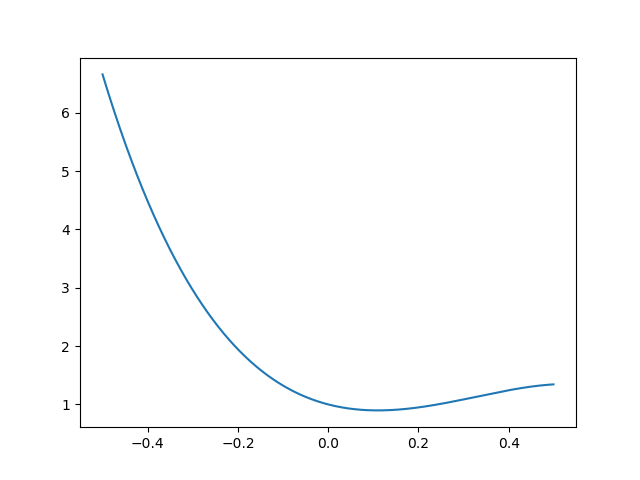

In [36]:
def optimizee(x):
    return -5*x**5 + 4*x**4 - 12*x**3 + 11*x**2 - 2*x + 1

dx = 0.001
domain = np.arange(-0.5,0.5,dx)
domain.shape
plt.plot(domain,optimizee(domain));

In [68]:
x, fx = dichoSearch(-0.5,0.5,f,3e-6,1e-5,1e-8,False)
print('Minimizer found: ', x)
print('Minimum found: ', fx)

Minimizer found:  0.10986295166015625
Minimum found:  0.8976329719133278


In [77]:
x, fx = fiboSearch(-0.5,0.5,f,14,False)
print('Minimizer found: ', x)
print('Minimum found: ', fx)

Minimizer found:  0.10983606557377047
Minimum found:  0.8976329760305806


In [5]:
x, fx = goldenSearch(-0.5,0.5,f,1e-5,False)
print('Minimizer found: ', x)
print('Minimum found: ', fx)

Minimizer found:  0.109857691207
Minimum found:  0.897632971932


In [56]:
x, fx = quadraticSearch(-0.5,0.5,f,1e-5,False)
print('Minimizer found: ', x)
print('Minimum found: ', fx)

Minimizer found:  0.10986188638512226
Minimum found:  0.8976329719244117


### Results

In [44]:
# df = pd.DataFrame(columns=['algo','func'])
df = pd.DataFrame(index=['Dichotomous','Fibonacci','Golden-section',
                         'Quadratic interpolation','Cubic interpolation',
                         'Davies-Swann-Campey', 'Backtracking line'],
                          columns=['func1','func2','func3'])
df

,func1,func2,func3
Dichotomous,NaN,NaN,NaN
Fibonacci,NaN,NaN,NaN
Golden-section,NaN,NaN,NaN
Quadratic interpolation,NaN,NaN,NaN
Cubic interpolation,NaN,NaN,NaN
Davies-Swann-Campey,NaN,NaN,NaN
Backtracking line,NaN,NaN,NaN


In [58]:
x = np.array((-5, 0, 5))
f(x)

array([ 19911,      1, -14359])